In [ ]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt

In [ ]:
def load_character_detection_model():
    character_model_path = r"C:\\Users\\X\\Desktop\\X\\runs\\detect\\train2\\weights\\characterdetection.pt"
    return YOLO(character_model_path)
character_model = load_character_detection_model()
character_classes=[
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'BA', 'BAGMATI', 'CHA',
    'GA', 'GANDAKI', 'HA', 'JA', 'JHA', 'KA', 'KHA', 'KO', 'LU', 'LUMBINI',
    'MA', 'MADESH', 'ME', 'NA', 'PA', 'PRA', 'PRADESH', 'RA', 'SU', 'VE', 'YA']

In [ ]:
def calculate_dynamic_threshold(characters, num_lines, min_threshold=15, max_threshold=50):
    if len(characters) < 2:
        return max_threshold
    horizontal_distances = [abs(characters[i]['x'] - characters[i - 1]['x']) for i in range(1, len(characters))]
    avg_distance = np.mean(horizontal_distances)
    line_adjustment = np.clip(100 / (num_lines + 1), 15, 30)
    return np.clip(avg_distance / 2 + line_adjustment, min_threshold, max_threshold)

def optimized_sort_characters(characters, dynamic_threshold=True):
    characters.sort(key=lambda x: x['y'])
    lines, current_line = [], []
    threshold = calculate_dynamic_threshold(characters, len(set(round(char['y']) for char in characters))) if dynamic_threshold else 25
    for char in characters:
        if not current_line or abs(current_line[-1]['y'] - char['y']) < threshold:
            current_line.append(char)
        else:
            lines.append(sorted(current_line, key=lambda x: x['x']))
            current_line = [char]
    if current_line:
        lines.append(sorted(current_line, key=lambda x: x['x']))
    return sorted(lines, key=lambda line: line[0]['y'])

In [ ]:
def test_character_detection(extracted_plate):
    gray_image = cv2.cvtColor(extracted_plate, cv2.COLOR_BGR2GRAY)
    gray_image_resized = cv2.resize(gray_image, (640, 640))
    gray_image_3channel = cv2.cvtColor(gray_image_resized, cv2.COLOR_GRAY2BGR)

    results = character_model(gray_image_3channel, conf=0.5)
    detected_classes = results[0].boxes.cls.cpu().numpy()
    boxes = results[0].boxes.xywh.cpu().numpy()

    characters = [
        {'class': character_classes[int(cls)], 'x': box[0], 'y': box[1], 'w': box[2], 'h': box[3]}
        for cls, box in zip(detected_classes, boxes)
        if int(cls) < len(character_classes)]

    sorted_characters = optimized_sort_characters(characters)
    sorted_string = ''.join([char['class'] for line in sorted_characters for char in line])

    for char in characters:
        x, y, w, h = int(char['x']), int(char['y']), int(char['w']), int(char['h'])
        cv2.rectangle(gray_image_resized, (x - w // 2, y - h // 2), (x + w // 2, y + h // 2), (255, 0, 0), 2)
        cv2.putText(gray_image_resized, char['class'], (x - w // 2, y - h // 2 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.figure(figsize=(5,5))
    plt.imshow(gray_image_resized, cmap='gray')
    plt.axis('off')
    plt.show()
    print(f"Detected Characters: {sorted_string}")



0: 640x640 1 0, 1 5, 2 6s, 1 7, 1 BA, 1 CHA, 6.1ms
Speed: 4.6ms preprocess, 6.1ms inference, 162.3ms postprocess per image at shape (1, 3, 640, 640)


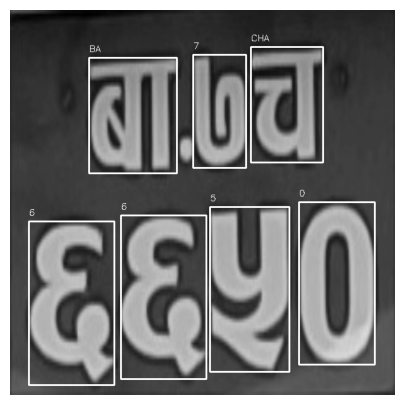

Detected Characters: BA7CHA6650


In [ ]:
extracted_plate = cv2.imread(r'C:\Users\X\Desktop\extracted plates\plate2.jpg')
test_character_detection(extracted_plate)